### 1. [MNIST 사진 인식 신경망 훈련]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda=False
if torch.cuda.is_available():
 is_cuda = True

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

sample_data = next(iter(train_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 11824221.06it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 5104749.00it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11522740.77it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [4]:
def plot_img(image):
 image = image.numpy()[0]
 mean = 0.1307
 std = 0.3081
 image = ((image * std) + mean)
 plt.imshow(image,cmap='gray')

***
#### 1-(1), (2) 출력확인

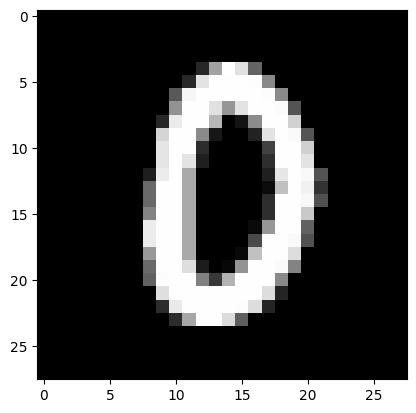

In [5]:
plot_img(sample_data[0][2])

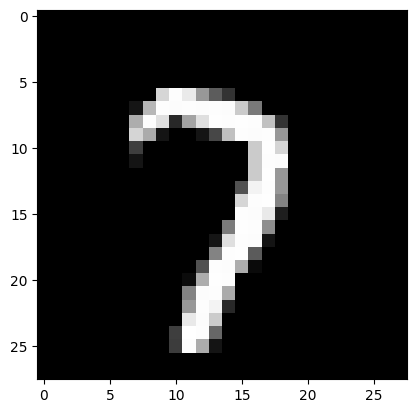

In [6]:
plot_img(sample_data[0][1])

***
**신경망 모델 정의**

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

***
**모델 instance생성 & optimizer설정**

In [8]:
model = Net()
if is_cuda:
    model.cuda()

In [9]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

data , target = next(iter(train_loader))
if is_cuda:
    output = model(Variable(data.cuda()))
else:
    output = model(Variable(data))

***
#### 1-(3),(4) 출력 확인

In [10]:
print(output.size(), target.size())

torch.Size([32, 10]) torch.Size([32])


***
**모델 학습**

In [13]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
    volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)

    running_loss += F.nll_loss(output,target,size_average=False).data.item()
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
    if phase == 'training':
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    
    return loss, accuracy


In [14]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.0012 and training accuracy is 3/60000     0.005
validation loss is 0.0037 and validation accuracy is 1/10000      0.01
training loss is 0.0012 and training accuracy is 6/60000      0.01
validation loss is 0.0036 and validation accuracy is 0/10000       0.0
training loss is 0.0012 and training accuracy is 4/60000  0.006667
validation loss is 0.0037 and validation accuracy is 0/10000       0.0
training loss is 0.0012 and training accuracy is 4/60000  0.006667
validation loss is 0.0037 and validation accuracy is 0/10000       0.0
training loss is 0.0012 and training accuracy is 5/60000  0.008333
validation loss is 0.0037 and validation accuracy is 1/10000      0.01
training loss is 0.0012 and training accuracy is 3/60000     0.005
validation loss is 0.0036 and validation accuracy is 0/10000       0.0
training loss is 0.0012 and training accuracy is 3/60000     0.005
validation loss is 0.0036 and validation accuracy is 2/10000      0.02
training loss is 0.0012 and traini

***
#### 1-(5),(6) 출력 확인

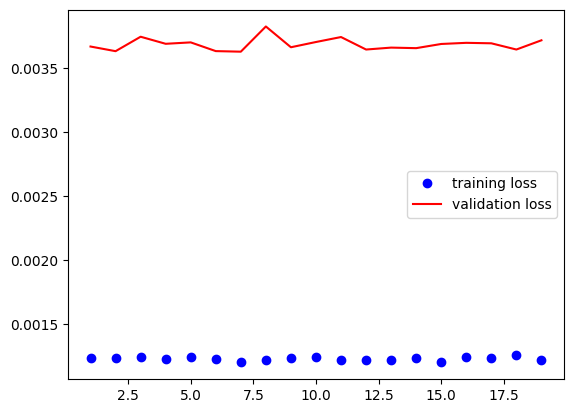

In [15]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

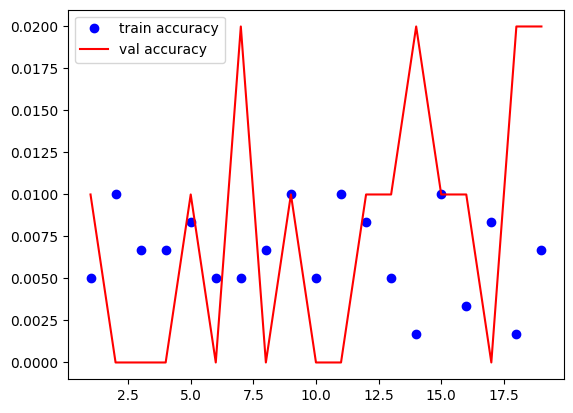

In [16]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()